In [ ]:
import pandas as pd
import numpy as np
import string
import cv2
import re
import nltk
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Embedding, LSTM, TimeDistributed, Concatenate, RepeatVector, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
path = '../input/flickr8k-sau/Flickr_Data/Images/'

In [4]:
from glob import glob
Images = glob(path+'*.jpg')
len(Images)

8091

In [5]:
Images = Images[0:2000]

In [ ]:
resnet = ResNet50(include_top = True)

last = resnet.layers[-2].output
model1 = Model(inputs = resnet.input, outputs=last)

In [ ]:
# Create Image_features dict 
Image_features = {}
for img in Images:
  img_ = cv2.imread(img)
  img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
  img_ = cv2.resize(img_, (224, 224))
  img_ = img_.reshape(1, 224, 224, 3)
  pred = model1.predict(img_).reshape(2048,)
  img_name = img.split('/')[-1]
  Image_features[img_name] =  pred

In [11]:
len(Image_features)

2000

In [12]:
caption_path = '../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
captions_data = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [13]:
captions_data.__len__()

40461

In [14]:
captions= {}
try:
  for i in captions_data:
      img = i.split('\t')[0][:-2] 
      caption = i.split('\t')[-1]
      if img in Image_features:
        if img not in captions:
          captions[img] = [caption]
        else:
          captions[img].append(caption)
except:
  pass

In [15]:
captions.__len__()

2000

In [16]:
# add 'start' and 'end' to text
def preprocess(txt):
    modified = txt.lower()
    trans = ("", "", string.punctuation)
    modified = modified.translate(trans)
    stop_words = set(stopwords.words('english'))
    modified = ' '.join(modified.split())
    tokens = nltk.word_tokenize(modified)
    tokens = [token for token in tokens if token not in stop_words]
    modified = ' '.join(tokens)
    modified = 'start ' + modified + ' end'
    return modified

for i, t in captions.items():
    for t_ in t:
        captions[i][t.index(t_)] = preprocess(t_)

In [17]:
# Vocabulary Dictionary
count_words = {}
count = 0
for k,vv in captions.items():
    for v in vv:
        for word in v.split():
            if word not in count_words.keys():
                count_words[word] = count
                count+=1

In [18]:
len(count_words)

4601

In [19]:
# Encoding the text
for i, t in captions.items():
  for t_ in t:
    encoded = []
    for word in t_.split():
      encoded.append(count_words[word])
    captions[i][t.index(t_)] = encoded

In [21]:
# Maximum length in single caption
Max_len = 0
for i, t in captions.items():
  for t_ in t:
    if len(t_) > Max_len:
      Max_len = len(t_)
print(Max_len)

23


In [22]:
vocab_size = len(count_words)
def X_generator(photo, caption):
  X = []

  for k, vv in caption.items():
    for v in vv:
      for i in range(1, len(v)):
        X.append(photo[k])
  return np.array(X)

def Y_in_generator(caption):
  Y_IN = []
  for k, vv in caption.items():
    for v in vv:
      for i in range(1, len(v)):
        in_seq = [v[:i]] #Every time it takes +=1 items
        in_seq = pad_sequences(in_seq, padding = 'post', maxlen = Max_len)[0]
        Y_IN.append(in_seq)
  return np.array(Y_IN)

def Y_out_generator(caption):
  Y_OUT = []
  for k, vv in caption.items():
    for v in vv:
      for i in range(1, len(v)):
        out_seq = v[i]
        out_seq = to_categorical([out_seq], num_classes=vocab_size+1 )[0] 
        Y_OUT.append(out_seq)
  return Y_OUT


In [23]:
X = X_generator(Image_features, captions)

In [24]:
Y_in = Y_in_generator(captions)

In [25]:
Y_out = Y_out_generator(captions)

In [26]:
print(X.__len__(), Y_in.__len__(), Y_out.__len__())

82801 82801 82801


In [27]:
X = np.array(X)
Y_in = np.array(Y_in, dtype='float64')
Y_out = np.array(Y_out, dtype='float64')

In [28]:
embedding_size = 128
max_len = Max_len
vocab_size = len(count_words)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

concate = Concatenate()([image_model.output, language_model.output])
concate = LSTM(128, return_sequences=True)(concate)
concate = LSTM(512, return_sequences=False)(concate)
concate = Dense(vocab_size+1)(concate)
out = Activation('softmax')(concate)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 23, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 128)           588928    
_________________________________________________________________
lstm (LSTM)                  (None, 23, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 23, 128)           32896     
Total params: 1,016,064
Trai

In [29]:
model.fit([X, Y_in], Y_out, batch_size=512, epochs=100)

2021-11-23 10:16:37.607829: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1524200808 exceeds 10% of free system memory.


Epoch 1/100
162/162 [==============================] - 12s 52ms/step - loss: 6.1636 - accuracy: 0.1161
Epoch 2/100
162/162 [==============================] - 8s 52ms/step - loss: 5.1356 - accuracy: 0.2342
Epoch 3/100
162/162 [==============================] - 8s 52ms/step - loss: 4.8139 - accuracy: 0.2497
Epoch 4/100
162/162 [==============================] - 8s 52ms/step - loss: 4.5936 - accuracy: 0.2680
Epoch 5/100
162/162 [==============================] - 8s 52ms/step - loss: 4.4472 - accuracy: 0.2759
Epoch 6/100
162/162 [==============================] - 8s 52ms/step - loss: 4.3548 - accuracy: 0.2800
Epoch 7/100
162/162 [==============================] - 8s 52ms/step - loss: 4.2584 - accuracy: 0.2842
Epoch 8/100
162/162 [==============================] - 8s 52ms/step - loss: 4.1839 - accuracy: 0.2868
Epoch 9/100
162/162 [==============================] - 8s 52ms/step - loss: 4.0425 - accuracy: 0.2980
Epoch 10/100
162/162 [==============================] - 8s 52ms/step - loss: 3.94

In [30]:
model1.save('resnet50.h5')

In [31]:
model.save('image_caption_pred.h5')
model.save_weights('weights.h5')
np.save('vocab', count_words)

In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from tensorflow.keras.preprocessing.sequence import  pad_sequences
from matplotlib import pyplot as plt

model1 = load_model(r"C:\Users\welcome\Data Science\Deep Learning\CNN\Image_Captioning_Flickr\resnet50.h5")
model = load_model(r"C:\Users\welcome\Data Science\Deep Learning\CNN\Image_Captioning_Flickr\image_caption_pred.h5")
model.load_weights(r"C:\Users\welcome\Data Science\Deep Learning\CNN\Image_Captioning_Flickr\weights.h5")
vocab = np.load(r"C:\Users\welcome\Data Science\Deep Learning\CNN\Image_Captioning_Flickr\vocab.npy", allow_pickle=True)

In [2]:
img_path = r"C:\Users\welcome\Downloads\cat.jpg"

In [3]:
def getImage(img_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (224, 224))

    img = np.reshape(img, (1,224, 224,3))
    
    return img

In [4]:
count_words = vocab.flatten()[0]
inverse_dict = {v:k for k,v in count_words.items()}

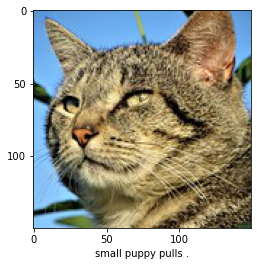

In [5]:
caption = ''
text_input = ['start']
Max_len = 23
image = model1.predict(getImage(img_path)).reshape(1, 2048)
count = 0
while count < Max_len:
    count = count+1
    
    encoded = list()
    for x in text_input:
        encoded.append(count_words[x])
    
    encoded = pad_sequences([encoded], padding='post', truncating='post', maxlen=Max_len)
    
    prediction = np.argmax(model.predict([image, encoded]))
    word = inverse_dict[prediction]
    caption =caption + ' '+ word
    if word == 'end':
            break

    text_input.append(word)
    text = " ".join(text_input[1:])
plt.figure()
plt.imshow(plt.imread(img_path))
plt.xlabel(text,)
plt.rcParams['font.size'] = 20
plt.show()

In [ ]:
!streamlit run my_app.py